## convet CIFAR10 dataset to TFRecord

In [49]:
import tensorflow as tf
tf.reset_default_graph()
import os
from os.path import join
import matplotlib.pyplot as plt

'''Parse funciton'''
def _parse_function(filename):
    image_bytes = tf.read_file(filename)
    image_value = tf.image.decode_png(image_bytes, channels=3)
    
#     image_value = tf.image.convert_image_dtype(image_value, dtype=tf.float32)
    image_value = tf.cast(image_value, tf.uint8)
    
    return image_value
'''Datas tran to aimed type.'''
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

'''Read file from path.'''
# image_path = "./images"
image_path = "./CIFAR_images"
image_names = os.listdir(image_path)
file_names = [join(image_path, f) for f in image_names]
# print("file names: {}".format(file_names))
print("files number: {}".format(len(file_names)))
'''File name queue.'''
filename_queue = tf.data.Dataset.from_tensor_slices(file_names)
'''Read image and get image matrics.'''
image_map = filename_queue.map(_parse_function)
'''Iterator the image value.'''
image_value = image_map.make_one_shot_iterator().get_next()
# height = 128
# width = 128
'''image number:100.'''
image_num = len(file_names)

'''save image value.'''
images = []
def image_info(images):
    width, height, channels = images[0].shape
#     print("image value: {}".format(images[0]))
    print("width: {}, height: {}, channels: {}".format(width, height, channels))
    
def image_show(sess, image_num, image_value):
    plt.figure(figsize=(10, 10))
    for i in range(image_num):
        '''image type: <dtype: 'uint8'>'''
#         print("image type: {}".format(image_value.dtype))
        if image_value.dtype != tf.float32:
            '''
            Convert image to float32 type, and value range in [0,1].
            image type: <dtype: 'float32'>
            '''
            image_value = tf.image.convert_image_dtype(image_value, dtype=tf.float32)
        image_value = tf.image.resize_images(image_value, [28, 28], method=0)
        if image_value.dtype == tf.float32:
            '''Convert image to unsigned integer type, and value range [0, 255]'''
            image_value = tf.image.convert_image_dtype(image_value, dtype=tf.uint8)
        image_values = sess.run(image_value)
        '''Show images.'''
        plt.subplot(10,10,i+1).set_title("fig{}".format(i+1))
        plt.subplots_adjust(hspace=0.1, wspace=0.6)
        plt.imshow(image_values)
        plt.axis("off")
    plt.show()
    
def process_image(sess, image_num, image_value):
    for i in range(image_num):
        if image_value.dtype != tf.float32:
            '''Convert image to float32 type, and value range in [0,1], Tensor'''
            image_value = tf.image.convert_image_dtype(image_value, dtype=tf.float32)
        image_value = tf.image.resize_images(image_value, [28, 28], method=0)
        if image_value.dtype == tf.float32:
            '''Convert image to unsigned integer type, and value range [0, 255], Tensor'''
            image_value = tf.image.convert_image_dtype(image_value, dtype=tf.uint8)
            '''Image matrix.
            [[[ 63  48  18]
              [ 64  53  21]
              [ 62  54  22]
              ...
              [104  76  45]]]
            '''
        image_values = sess.run(image_value)
        images.append(image_values)
    return images
def save_tfrecord(images):
    if not os.path.exists("outputs/"):
        os.makedirs("outputs/")
    file_name = "./outputs/cifar10.tfrecords"
    writer = tf.python_io.TFRecordWriter(file_name)
    for i in range(image_num):
        image_raw = images[i].tostring()
        example = tf.train.Example(features=tf.train.Features(feature={
            'image_raw':_bytes_feature(image_raw),
            'image_num':_int64_feature(image_num),
            'height':_int64_feature(28),
            'width':_int64_feature(28)
        }))
        writer.write(example.SerializeToString())
    writer.close()
    print("Saved.")
    
'''Strat save.'''    
with tf.Session() as sess:
    
#     image_show(sess, image_num, image_value)
    images = process_image(sess, image_num, image_value)
    print("image number: {}".format(len(images)))
    '''width: 28, height: 28, channels: 3'''
    image_info(images)
    save_tfrecord(images)
    
    
    

files number: 100
image number: 100
width: 28, height: 28, channels: 3
Saved.


## Read TFRecord data.

images iterator: Tensor("IteratorGetNext:0", shape=(), dtype=string)


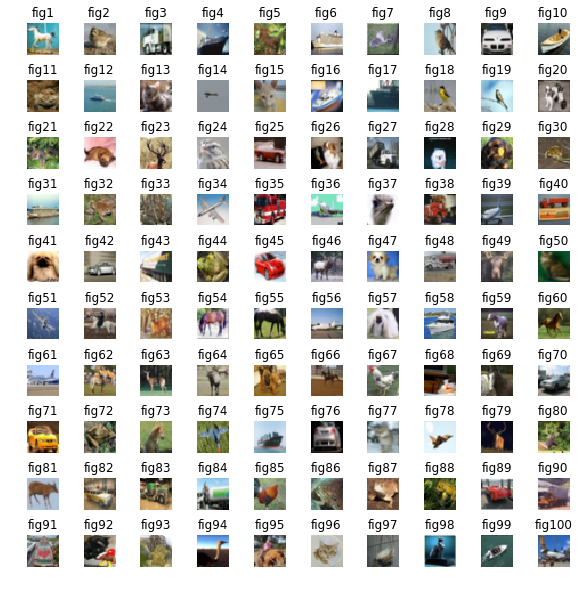

In [58]:
import tensorflow as tf
tf.reset_default_graph()
import matplotlib.pyplot as plt
import cv2

'''batch size'''
BATCH_SIZE = 100
'''Parse TFRecord data function.'''
def parse(record):
    features = tf.parse_single_example(
        record,
        features={"image_raw":tf.FixedLenFeature([], tf.string),
                  "image_num":tf.FixedLenFeature([], tf.int64),
                  "height":tf.FixedLenFeature([], tf.int64),
                  "width":tf.FixedLenFeature([], tf.int64),
                 }
    )
    return features["image_raw"],features["image_num"], features["height"],features["width"]
#     return features["image_raw"]

'''TFRecord path.'''
input_files = ["./outputs/cifar10.tfrecords"]
dataset = tf.data.TFRecordDataset(input_files)
'''Data Map.'''
dataset = dataset.map(parse)
'''batch data'''
# dataset = dataset.batch(BATCH_SIZE)
'''Iterator initializer.'''
# iterator = dataset.make_one_shot_iterator()
iterator = dataset.make_initializable_iterator()
images, num, height, width = iterator.get_next()
# images = iterator.get_next()
'''images iterator: Tensor("IteratorGetNext:0", shape=(), dtype=string)'''
print("images iterator: {}".format(images))
# images = iterator.get_next()

def iterator_data_subplot(sess, num, images, height, width):
    plt.figure(figsize=(10, 10))
    for i in range(num):
        '''Recovery data.
        Tensor("DecodeRaw:0", shape=(?,), dtype=uint8)
        '''
        image = tf.decode_raw(images, tf.uint8)
        '''image value:
        Tensor("DecodeRaw:0", shape=(?,), dtype=uint8)
        '''
        height = tf.cast(height, tf.int32)
        width = tf.cast(width, tf.int32)
        '''image info.
        image shape: (49152,), height: 28, width: 28
        '''
        '''Reshape image to standard.'''
        image = tf.reshape(image, [height, width, 3])
        '''Image matrix.
        [[[165 170 176]
          [161 167 173]
          ...
          [139 148 155]]]
        '''
        image = sess.run(image)
        '''Show image.'''
        plt.subplot(10,10,i+1).set_title("fig{}".format(i+1))
        plt.subplots_adjust(hspace=0.8)
        plt.axis("off")
        plt.imshow(image)
    plt.show()

def iterator_data_plot(sess, num, images, height, width):
    plt.figure()
    for i in range(num):
        '''Recovery data.
        Tensor("DecodeRaw:0", shape=(?,), dtype=uint8)
        '''
        image = tf.decode_raw(images, tf.uint8)
        height = tf.cast(height, tf.int32)
        width = tf.cast(width, tf.int32)
        image_shape, height, width = sess.run([image, height, width])
        '''image shape: (49152,), height: 128, width: 128'''
        print("image shape: {}, height: {}, width: {}".format(image_shape.shape, height, width))
        image = tf.reshape(image, [height, width, 3])
        image = sess.run(image)
        plt.title("fig{}".format(i+1))
        plt.axis("off")
        plt.imshow(image)
        plt.show()
    
with tf.Session() as sess:
    '''Initializer the iterator.'''
    sess.run(iterator.initializer)    
    iterator_data_subplot(sess, 100, images, height, width)
#     iterator_data_plot(sess, 10, images, height, width)
    
    

## Set batch and split data into multi parts.

images iterator: Tensor("IteratorGetNext:0", shape=(?,), dtype=string)
image column vector: (25, 2352)


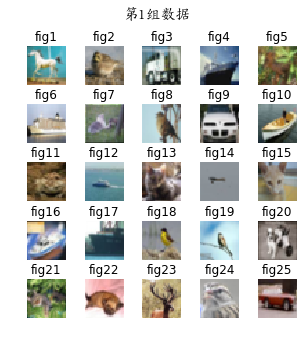

image column vector: (25, 2352)


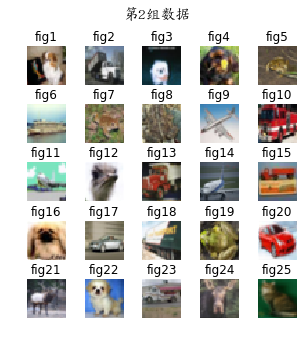

image column vector: (25, 2352)


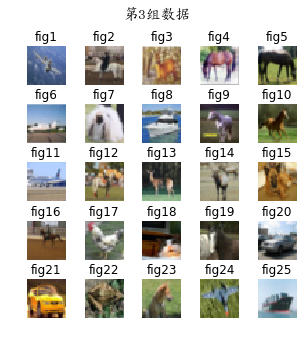

image column vector: (25, 2352)


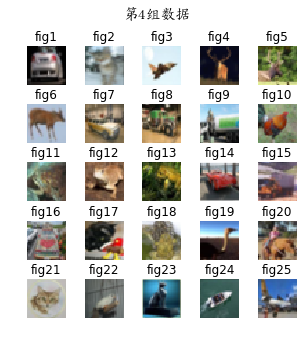

In [64]:
import tensorflow as tf
tf.reset_default_graph()
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font = FontProperties(fname="/usr/share/fonts/truetype/arphic/ukai.ttc")

'''batch size'''
BATCH_SIZE = 25
'''Parse TFRecord data function.'''
def parse(record):
    features = tf.parse_single_example(
        record,
        features={"image_raw":tf.FixedLenFeature([], tf.string),
                  "image_num":tf.FixedLenFeature([], tf.int64),
                  "height":tf.FixedLenFeature([], tf.int64),
                  "width":tf.FixedLenFeature([], tf.int64),
                 }
    )
    image_raw = features["image_raw"]
    image_num = features["image_num"]
    height = features["height"]
    width = features["width"]
#     return features["image_raw"],features["image_num"], features["height"],features["width"]
#     return image, image_num, height, width
    return image_raw

'''TFRecord path.'''
input_files = ["./outputs/cifar10.tfrecords"]
dataset = tf.data.TFRecordDataset(input_files)
'''Data Map.'''
dataset = dataset.map(parse)
# dataset = dataset.map(lambda image: image_raw)
'''batch data'''
dataset = dataset.batch(BATCH_SIZE)
'''set epoch numbers.'''
# EPOCH_NUM = 3
# dataset = dataset.repeat(EPOCH_NUM)
'''Iterator initializer.'''
# iterator = dataset.make_one_shot_iterator()
iterator = dataset.make_initializable_iterator()
# images, num, height, width = iterator.get_next()
images = iterator.get_next()
'''images iterator: Tensor("IteratorGetNext:0", shape=(), dtype=string)'''
print("images iterator: {}".format(images))
# images = iterator.get_next()
def show_image(image,i):
#     plt.subplot(20,20,i+1).
    plt.imshow(image)
    plt.title("fig{}".format(i))

def iterator_infinite(sess, images):
    '''Unknown number of images we can use this method which read data cannot stop until itearte finished queue.'''
    image_num = 0
    while True:
        try:
            image = tf.decode_raw(images, tf.uint8)
            image_shape = sess.run(image)
            image_num += 1
            print("The {}th image, image column vector: {}".format(image_num, image_shape.shape))
        except tf.errors.OutOfRangeError:
            print("Total iamge number: {}".format(image_num))
            break
def iterator_loop(sess, images, nums):
    '''Iterate the data in loop
    total images are 100, batch size 25,
    split the data into 4 part.
    '''
    image_batch = []
    for i in range(nums):
        image = tf.decode_raw(images, tf.uint8)
        image_batch.append(image)
        
    return image_batch

            
with tf.Session() as sess:
    sess.run(iterator.initializer)
    image_batch = iterator_loop(sess, images, 4)
    for order, image in enumerate(image_batch):
        image = sess.run(image)
        print("image column vector: {}".format(image.shape))
        plt.figure(figsize=(5, 5))
        plt.suptitle("第{}组数据".format(order+1), fontproperties=font, x=0.5, y=0.99, fontsize=15)
        for i in range(25):
            reshape_image = tf.reshape(image[i], [28, 28, 3])
            plt.subplot(5, 5, i+1).set_title("fig{}".format(i+1))
            plt.subplots_adjust(hspace=0.5)
            plt.axis("off")
            
            plt.imshow(reshape_image.eval())
        plt.show()